# Import modules

In [ ]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from math import sqrt
import itertools

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: Train/
  inflating: Train/bangkok_Train.csv  
  inflating: Train/chiangmai_Train.csv  
  inflating: Train/chanthaburi_Train.csv  
  inflating: Train/songkhla_Train.csv  
  inflating: Train/khonkaen_Train.csv  
  inflating: Train/kanchanaburi_Train.csv  
   creating: Test/
  inflating: Test/kanchanaburi_Test.csv  
  inflating: Test/chiangmai_Test.csv  
  inflating: Test/chanthaburi_Test.csv  
  inflating: Test/khonkaen_Test.csv  
  inflating: Test/bangkok_Test.csv   
  inflating: Test/songkhla_Test.csv  


# ARIMA POC

In [ ]:
df_bkk = pd.read_csv('data/Train/bangkok_Train.csv')
df_bkk.head(5)

,datetime,Temp(C),lat,long,WindDir,Wind Speed(km/h),PM2.5
0,2016-03-03 15:00:00,32.55,12.6096,102.1045,60.000000,10.500000,44.2
1,2016-03-03 16:00:00,31.70,12.6096,102.1045,55.000000,10.000000,44.2
2,2016-03-03 17:00:00,30.20,12.6096,102.1045,58.333333,12.333333,44.3
3,2016-03-03 18:00:00,28.70,12.6096,102.1045,61.666667,14.666667,44.2
4,2016-03-03 19:00:00,27.20,12.6096,102.1045,65.000000,17.000000,34.2


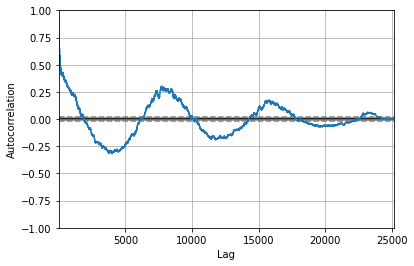

In [ ]:
autocorrelation_plot(df_bkk['PM2.5'])

In [ ]:
model_bkk = ARIMA(df_bkk['PM2.5'], order=(4, 1, 0))
model_bkk_fit = model_bkk.fit(disp=0)
print(model_bkk_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.PM2.5   No. Observations:                25135
Model:                 ARIMA(4, 1, 0)   Log Likelihood              -65814.520
Method:                       css-mle   S.D. of innovations              3.318
Date:                Fri, 16 Apr 2021   AIC                         131641.040
Time:                        18:58:40   BIC                         131689.832
Sample:                             1   HQIC                        131656.828
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.016     -0.025      0.980      -0.031       0.030
ar.L1.D.PM2.5     0.0245      0.006      3.919      0.000       0.012       0.037
ar.L2.D.PM2.5    -0.1629      0.006    -

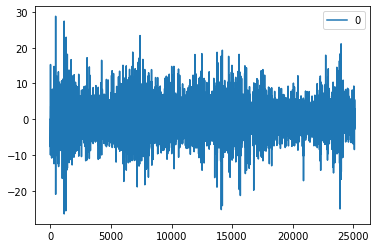

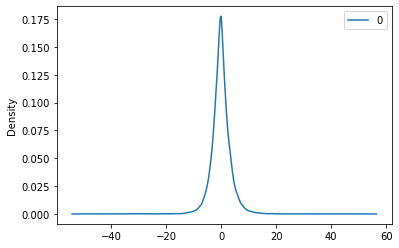

                  0
count  25135.000000
mean      -0.000050
std        3.318533
min      -26.478907
25%       -1.721907
50%       -0.086366
75%        1.629214
max       28.798884


In [ ]:
residuals = pd.DataFrame(model_bkk_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

# Training

In [ ]:
all_provinces = [('Chanthaburi','Chanthaburi'),('Chiang Mai','Chiang_Mai'),('Kanchanaburi','Kanchanaburi'),('Bangkok','Bangkok'),('Khon Kaen','Khon_Kaen'),('Songkhla','Songkhla')]
pred = []

fmt_prv = ['chanthaburi','chiangmai','kanchanaburi','bangkok','khonkaen','songkhla']

all_pm = []
all_pm_Test = []

all_exog = []
for i in range(6) :
    all_exog.append([])

all_exog_Test = []
for i in range(6) :
    all_exog_Test.append([])

for i in range(len(fmt_prv)) :
    
    # Train
    df = pd.read_csv('Train/'+fmt_prv[i]+'_Train.csv')
    all_exog[i].append(list(df['Temp(C)']))
    all_exog[i].append(list(df['WindDir']))
    all_exog[i].append(list(df['Wind Speed(km/h)']))
    all_pm.append(list(df['PM2.5']))

    # Test
    df = pd.read_csv('Test/'+fmt_prv[i]+'_Test.csv')
    all_exog_Test[i].append(list(df['Temp(C)']))
    all_exog_Test[i].append(list(df['WindDir']))
    all_exog_Test[i].append(list(df['Wind Speed(km/h)']))
    all_pm_Test.append(list(df['PM2.5']))

order = (4,1,4)
for i in range(len(fmt_prv)) :
    print(fmt_prv[i])
    exogx = np.array(all_exog[i][:]).T

    each_pred = []
    each_label = []
    exogx_test = np.array(all_exog_Test[i][:]).T
    pm_model = SARIMAX(all_pm[i],
                    order=order,
                    # seasonal_order=(1, 0, 0, 12),
                    exog=exogx,
                    enforce_stationarity=False,
                    enforce_invertibility=False
    )
    res = pm_model.fit()
    if exogx_test.shape[0] < 1454*72 :
        exogx_test = np.concatenate((exogx_test, np.array([list(exogx_test.mean(axis=0))] * ((1454*72)-exogx_test.shape[0]))), axis=0)
    
    for j in tqdm(range(1454)) :
        output = res.forecast(72 ,exog=exogx_test[6*j:6*j+72] ,dynamic=False)
        
        # add data for creating new model
        all_pm[i] += all_pm_Test[i][6*j:6*j+6]
        exogx = np.concatenate((exogx, exogx_test[6*j:6*j+6]), axis=0)
        each_pred += list(output)
        
        each_label += list(all_pm_Test[i][6*j:6*j+72])

    # RMS
    rms = sqrt(mean_squared_error(each_label, each_pred))
    print("RMS",rms)

    pred += each_pred

# Format output

In [ ]:
out_df = pd.DataFrame(np.array([[ i for i in range(len(pred))],pred]).T,columns=['Id','Expected'])
out_df['Id'] =  out_df['Id'].apply(lambda x : int(x+1))
out_df

,Id,Expected
0,1,128.667170
1,2,124.907576
2,3,121.077520
3,4,115.198572
4,5,110.041611
...,...,...
628123,628124,29.571174
628124,628125,29.571174
628125,628126,29.571174
628126,628127,29.571174


# Export csv

In [ ]:
out_df.to_csv('submission.csv',index=False)